In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pandas as pd
import pylhe
from tqdm import tqdm
import itertools

In [3]:
import os 
root_dirs = '../root/MG5_aMC_v2_7_3/3b3l/Events/'
root_names = ['run_01/tag_1_delphes_events.root', 'run_02/tag_1_delphes_events.root',
              'run_03/tag_1_delphes_events.root', 'run_04/tag_1_delphes_events.root',
              'run_05/tag_1_delphes_events.root', 'run_06/tag_1_delphes_events.root',
              'run_07/tag_1_delphes_events.root', 'run_08/tag_1_delphes_events.root',
              'run_09/tag_2_delphes_events.root', 'run_10/tag_2_delphes_events.root',
              'run_11/tag_2_delphes_events.root', 'run_12/tag_2_delphes_events.root',
              'run_13/tag_2_delphes_events.root', 'run_14/tag_2_delphes_events.root',
              'run_15/tag_2_delphes_events.root', 'run_16/tag_2_delphes_events.root',
              'run_17/tag_1_delphes_events.root', 'run_18/tag_1_delphes_events.root',
              'run_19/tag_1_delphes_events.root', 'run_20/tag_1_delphes_events.root',
              'run_21/tag_1_delphes_events.root', 'run_22/tag_1_delphes_events.root',
              'run_23/tag_1_delphes_events.root', 'run_24/tag_1_delphes_events.root']
f_tA = [uproot.open(root_dirs + name) for i, name in enumerate(root_names)]

In [4]:
def f(deltaeta, deltaphi):
    return np.sqrt(deltaeta**2 + deltaphi**2)
def function(f_Att, cs):
    # Define Tree
    tree_electron_Att = f_Att['Delphes;1/Electron']
    tree_muon_Att = f_Att['Delphes;1/Muon']
    tree_jet_Att = f_Att['Delphes;1/Jet']
    tree_Emiss_Att = f_Att['Delphes;1/MissingET']
    
    # Define Branches
    Att_electron = tree_electron_Att.arrays(['Electron.Charge',
                                            'Electron.PT',
                                            'Electron.Eta',
                                            'Electron.Phi'], library='ak')
    Att_muon = tree_muon_Att.arrays(['Muon.Charge',
                                    'Muon.PT',
                                    'Muon.Eta',
                                    'Muon.Phi'], library='ak')
    Att_jet = tree_jet_Att.arrays(['Jet.Mass',
                                   'Jet.BTag',
                                   'Jet.PT',
                                   'Jet.Eta', 
                                   'Jet.Phi'], library='ak')
    Att_Emiss = tree_Emiss_Att.arrays(['MissingET.MET',
                                       'MissingET.Phi'], library='ak')
    
    # Define Variables
    EventSize = len(Att_jet['Jet.Mass'])
    jet_sort_pt = ak.sort(Att_jet['Jet.PT'], axis=-1, ascending=False)
    jet_num = ak.num(Att_jet['Jet.PT'], axis=-1)
    lepton_sort_pt = ak.sort(ak.concatenate([Att_electron['Electron.PT'], Att_muon['Muon.PT']], axis=-1), axis=-1, ascending=False)
    lepton_charge = ak.Array.tolist(ak.concatenate([Att_electron['Electron.Charge'], Att_muon['Muon.Charge']], axis=-1))
    lepton_eta = ak.concatenate([Att_electron['Electron.Eta'], Att_muon['Muon.Eta']], axis=-1)
    lepton_phi = ak.concatenate([Att_electron['Electron.Phi'], Att_muon['Muon.Phi']], axis=-1)
    bjet_pt = Att_jet['Jet.PT']*Att_jet['Jet.BTag']
    bjet_eta = Att_jet['Jet.Eta']*Att_jet['Jet.BTag']
    bjet_phi = Att_jet['Jet.Phi']*Att_jet['Jet.BTag']
    three_lepton = ak.where(ak.num(lepton_sort_pt)>=3)
    
    # At least three leptons and three b-jets
    event_signal = []
    for i in tqdm(three_lepton[0]): #Awkward Array has a length of 1
        b_pt = bjet_pt[i]
        num_bjet = len(b_pt[ak.where(b_pt)])
        if num_bjet >= 3:
            event_signal.append(i)
        
    # Transverse Momentum of leading and subleading lepton & Eta for Leptons
    event_lep = []
    for i in tqdm(event_signal):
        lep_eta = lepton_eta[i]
        lep_where = ak.where(np.abs(lep_eta)<2.5, 0, lep_eta)
        if lepton_sort_pt[i][2] > 25 and ak.count_nonzero(lep_where) == 0:
            event_lep.append(i)
        else:
            continue
    
    # Transverse Momentum of leading and subleading b-jet & Eta for b-jets
    event_jet = []
    for i in tqdm(event_lep):
        b_pt, b_eta  = bjet_pt[i], bjet_eta[i]
        b_pt = b_pt[ak.where(b_pt)]
        b_pt = ak.sort(b_pt, ascending=False)
        bjet_where = ak.where(np.abs(b_eta)<2.5, 0, b_eta)
        if b_pt[2] > 20 and ak.count_nonzero(bjet_where) == 0:
            event_jet.append(i)
        else:
            continue
    
    # Emiss
    event_emiss = []
    for i in tqdm(event_jet):
        if Att_Emiss['MissingET.MET'][i] > 30:
            event_emiss.append(i)
        else:
            continue
 
    # delta R between b-jets and leptons, leptons and leptons, b-jets and b-jets
    event_deltaR_bl = []
    for i in tqdm(event_emiss):
        lep_eta, lep_phi, b_eta, b_phi = lepton_eta[i], lepton_phi[i], bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]

        deltaeta_bl = np.array([i-j for i in b_eta for j in lep_eta])
        deltaphi_bl = np.abs([i-j for i in b_phi for j in lep_phi])
        deltaphi_bl = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bl])
    
        if min(f(deltaeta_bl, deltaphi_bl)) > 0.4:
            event_deltaR_bl.append(i)
    
    event_deltaR_bb = []
    for i in tqdm(event_deltaR_bl):
        b_eta, b_phi = bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]
        
        m = b_eta - b_eta[:, np.newaxis]
        deltaeta_bb = m[np.triu_indices(len(m[0]), k = 1)]
        m = b_phi - b_phi[:, np.newaxis]
        deltaphi_bb = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_bb = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bb])
        
        if min(f(deltaeta_bb, deltaphi_bb)) > 0.4:
            event_deltaR_bb.append(i)
            
    event_deltaR_ll = []
    for i in tqdm(event_deltaR_bb):
        lep_eta, lep_phi = lepton_eta[i], lepton_phi[i]
        m = lep_eta - lep_eta[:, np.newaxis]
        deltaeta_ll = m[np.triu_indices(len(m[0]), k = 1)]
        m = lep_phi - lep_phi[:, np.newaxis]
        deltaphi_ll = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_ll = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_ll])

        if min(f(deltaeta_ll, deltaphi_ll)) > 0.4:
            event_deltaR_ll.append(i)
    
    # HT of 2 leading leptons and three leading jets
    event_ht = []
    for i in tqdm(event_deltaR_ll):
        lep_pt, jet_pt = lepton_sort_pt[i], jet_sort_pt[i]
        ht = np.sum([lep_pt[0], lep_pt[1], lep_pt[2], jet_pt[0], jet_pt[1], jet_pt[2]])
        if ht > 320:
            event_ht.append(i)
                
    cs = cs * 1000
    csf = cs * len(event_ht)/EventSize
                
    return [EventSize, len(event_signal), len(event_lep), len(event_jet), len(event_emiss), len(event_deltaR_bl), len(event_deltaR_bb), len(event_deltaR_ll), len(event_ht), cs, csf]

In [6]:
# Cross Section From Madgraph Generation
cs = np.array([0.0004204, 0.0002802, 0.0002031, 0.0001506, 0.0001135, 8.636e-05, 6.669e-05, 5.196e-05,
              0.002399, 0.003022, 0.002457, 0.001879, 0.001408, 0.001072, 0.0008196, 0.0006325,
              0.004124, 0.005722, 0.005036, 0.003953, 0.003101, 0.00235, 0.001851, 0.001444])

In [7]:
m1 = function(f_tA[0], cs[0])
m2 = function(f_tA[1], cs[1])
m3 = function(f_tA[2], cs[2])
m4 = function(f_tA[3], cs[3])
m5 = function(f_tA[4], cs[4])
m6 = function(f_tA[5], cs[5])
m7 = function(f_tA[6], cs[6])
m8 = function(f_tA[7], cs[7])
m9 = function(f_tA[8], cs[8])
m10 = function(f_tA[9], cs[9])
m11 = function(f_tA[10], cs[10])
m12 = function(f_tA[11], cs[11])
m13 = function(f_tA[12], cs[12])
m14 = function(f_tA[13], cs[13])
m15 = function(f_tA[14], cs[14])
m16 = function(f_tA[15], cs[15])
m17 = function(f_tA[16], cs[16])
m18 = function(f_tA[17], cs[17])
m19 = function(f_tA[18], cs[18])
m20 = function(f_tA[19], cs[19])
m21 = function(f_tA[20], cs[20])
m22 = function(f_tA[21], cs[21])
m23 = function(f_tA[22], cs[22])
m24 = function(f_tA[23], cs[23])

100%|██████████| 169/169 [00:00<00:00, 898.61it/s]


In [11]:
name = [r'Input Event Size',
        '3b3l Signature',
        r'Jet Selection',
        r'lepton Selection',
        r'$E_{T}^{miss}$ > 30GeV',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ Cut',
        'Cross Section after Merging and Matching (fb)',
        'Cross Section after Selection Cut (fb)']
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.1$': name,
                   r'$M_{A}=350 GeV$': m1,
                   r'$M_{A}=400 GeV$': m2,
                   r'$M_{A}=450 GeV$': m3,
                   r'$M_{A}=500 GeV$': m4,
                   r'$M_{A}=550 GeV$': m5,
                   r'$M_{A}=600 GeV$': m6,
                   r'$M_{A}=650 GeV$': m7,
                   r'$M_{A}=700 GeV$': m8
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.1$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
1,3b3l Signature,451.00000,574.000000,578.000000,606.000000,668.000000,626.000000,621.000000,635.000000
2,Jet Selection,277.00000,361.000000,363.000000,392.000000,453.000000,416.000000,434.000000,412.000000
3,lepton Selection,270.00000,358.000000,359.000000,384.000000,450.000000,408.000000,430.000000,403.000000
4,$E_{T}^{miss}$ > 30GeV,244.00000,330.000000,336.000000,353.000000,430.000000,378.000000,406.000000,376.000000
5,Δ$R_{bl}$ > 0.4,244.00000,330.000000,336.000000,353.000000,430.000000,378.000000,406.000000,376.000000
6,Δ$R_{bb}$ > 0.4,244.00000,330.000000,336.000000,353.000000,430.000000,378.000000,406.000000,376.000000
7,Δ$R_{ll}$ > 0.4,218.00000,309.000000,315.000000,328.000000,406.000000,363.000000,388.000000,359.000000
8,$H_{T}$ Cut,208.00000,292.000000,309.000000,325.000000,401.000000,361.000000,386.000000,359.000000
9,Cross Section after Merging and Matching (fb),0.42040,0.280200,0.203100,0.150600,0.113500,0.086360,0.066690,0.051960


In [12]:
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$': name,
                   r'$M_{A}=350 GeV$': m9,
                   r'$M_{A}=400 GeV$': m10,
                   r'$M_{A}=450 GeV$': m11,
                   r'$M_{A}=500 GeV$': m12,
                   r'$M_{A}=550 GeV$': m13,
                   r'$M_{A}=600 GeV$': m14,
                   r'$M_{A}=650 GeV$': m15,
                   r'$M_{A}=700 GeV$': m16
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
1,3b3l Signature,302.000000,300.00000,311.000000,329.000000,323.000000,334.000000,312.000000,323.000000
2,Jet Selection,175.000000,169.00000,164.000000,198.000000,189.000000,197.000000,197.000000,200.000000
3,lepton Selection,170.000000,166.00000,159.000000,195.000000,186.000000,195.000000,197.000000,193.000000
4,$E_{T}^{miss}$ > 30GeV,151.000000,145.00000,146.000000,179.000000,171.000000,179.000000,186.000000,184.000000
5,Δ$R_{bl}$ > 0.4,151.000000,145.00000,146.000000,179.000000,171.000000,179.000000,186.000000,184.000000
6,Δ$R_{bb}$ > 0.4,151.000000,145.00000,146.000000,179.000000,171.000000,179.000000,186.000000,184.000000
7,Δ$R_{ll}$ > 0.4,129.000000,132.00000,137.000000,167.000000,165.000000,167.000000,178.000000,180.000000
8,$H_{T}$ Cut,106.000000,120.00000,131.000000,163.000000,163.000000,164.000000,173.000000,179.000000
9,Cross Section after Merging and Matching (fb),2.399000,3.02200,2.457000,1.879000,1.408000,1.072000,0.819600,0.632500


In [13]:
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$': name,
                   r'$M_{A}=350 GeV$': m17,
                   r'$M_{A}=400 GeV$': m18,
                   r'$M_{A}=450 GeV$': m19,
                   r'$M_{A}=500 GeV$': m20,
                   r'$M_{A}=550 GeV$': m21,
                   r'$M_{A}=600 GeV$': m22,
                   r'$M_{A}=650 GeV$': m23,
                   r'$M_{A}=700 GeV$': m24
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000
1,3b3l Signature,264.000000,275.000000,316.000000,333.000000,314.00000,304.000000,320.000000,281.000000
2,Jet Selection,145.000000,159.000000,187.000000,210.000000,194.00000,178.000000,204.000000,188.000000
3,lepton Selection,142.000000,155.000000,184.000000,205.000000,191.00000,177.000000,203.000000,188.000000
4,$E_{T}^{miss}$ > 30GeV,120.000000,134.000000,169.000000,185.000000,170.00000,168.000000,187.000000,175.000000
5,Δ$R_{bl}$ > 0.4,120.000000,134.000000,169.000000,185.000000,170.00000,168.000000,187.000000,175.000000
6,Δ$R_{bb}$ > 0.4,120.000000,134.000000,169.000000,185.000000,170.00000,168.000000,187.000000,175.000000
7,Δ$R_{ll}$ > 0.4,103.000000,119.000000,159.000000,169.000000,165.00000,164.000000,185.000000,169.000000
8,$H_{T}$ Cut,99.000000,113.000000,152.000000,164.000000,160.00000,163.000000,185.000000,166.000000
9,Cross Section after Merging and Matching (fb),4.124000,5.722000,5.036000,3.953000,3.10100,2.350000,1.851000,1.444000


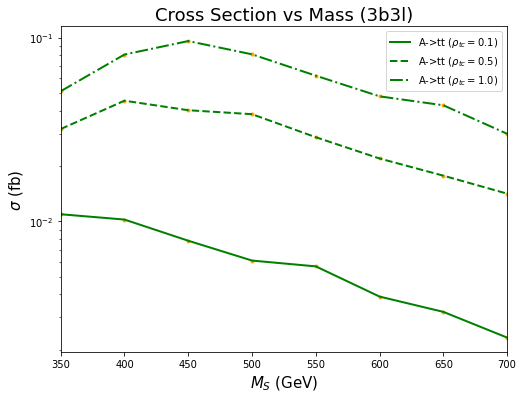

In [19]:
ma = np.linspace(350, 700, 8)
A3l_a01 = [m1[-1], m2[-1], m3[-1], m4[-1], m5[-1], m6[-1], m7[-1], m8[-1]]
A3l_a05 = [m9[-1], m10[-1], m11[-1], m12[-1], m13[-1], m14[-1], m15[-1], m16[-1]]
A3l_a10 = [m17[-1], m18[-1], m19[-1], m20[-1], m21[-1], m22[-1], m23[-1], m24[-1]]
plt.figure(figsize=(8, 6))
plt.scatter(ma, A3l_a01, marker='.', c='orange')
plt.scatter(ma, A3l_a05, marker='.', c='orange')
plt.scatter(ma, A3l_a10, marker='.', c='orange')
plt.xlim(350, 700)
plt.yscale('log')
plt.plot(ma, A3l_a01, 'g-', label=r'A->tt ($\rho_{tc}=0.1$)', linewidth=2)
plt.plot(ma, A3l_a05, 'g--', label=r'A->tt ($\rho_{tc}=0.5$)', linewidth=2)
plt.plot(ma, A3l_a10, 'g-.', label=r'A->tt ($\rho_{tc}=1.0$)', linewidth=2)

plt.title('Cross Section vs Mass (3b3l)', fontsize=18)
plt.xlabel(r'$M_{S}$ (GeV)', fontsize=15)
plt.ylabel(r'$\sigma$ (fb)', fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [15]:
def uncer(l, n):
    return(np.sqrt(f*(1-f)/n))

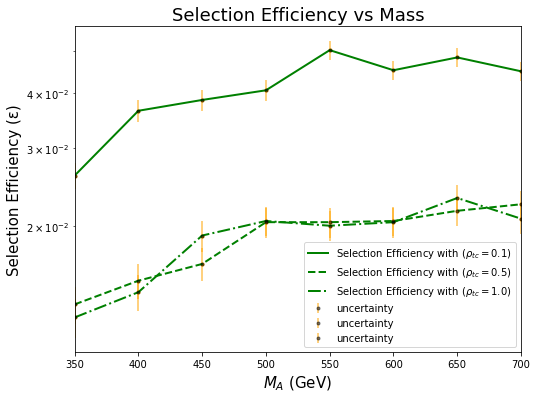

In [20]:
plt.figure(figsize=(8, 6))
ma = np.arange(350, 700+50, 50)
m = [m1, m2, m3, m4, m5, m6, m7, m8]
f = np.array([m[i][8]/m[i][0] for i in range(len(m))])
uf = uncer(f, 8000)
plt.scatter(ma, f, marker='.', c = 'orange')
plt.plot(ma, f, 'g-', label=r'Selection Efficiency with ($\rho_{tc}=0.1$)', linewidth=2)
plt.errorbar(ma, f, yerr=uf, fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0, label='uncertainty')

m = [m9, m10, m11, m12, m13, m14, m15, m16]
f = np.array([m[i][8]/m[i][0] for i in range(len(m))])
uf = uncer(f, 8000)
plt.scatter(ma, f, marker='.', c = 'orange')
plt.plot(ma, f, 'g--', label=r'Selection Efficiency with ($\rho_{tc}=0.5$)', linewidth=2)
plt.errorbar(ma, f, yerr=uf, fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0, label='uncertainty')

m = [m17, m18, m19, m20, m21, m22, m23, m24]
f = np.array([m[i][8]/m[i][0] for i in range(len(m))])
uf = uncer(f, 8000)
plt.scatter(ma, f, marker='.', c = 'orange')
plt.plot(ma, f, 'g-.', label=r'Selection Efficiency with ($\rho_{tc}=1.0$)', linewidth=2)
plt.errorbar(ma, f, yerr=uf, fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0, label='uncertainty')

plt.xlim(350, 700)
plt.yscale('log')
plt.title('Selection Efficiency vs Mass', fontsize=18)
plt.xlabel(r'$M_{A}$ (GeV)', fontsize=15)
plt.ylabel('Selection Efficiency (ε)', fontsize=15)
plt.legend(loc='lower right')
plt.show()